- Fonte: https://www.kaggle.com/kabure/kickstarter-projects-eda-stat-tests-pipeline#Modeling

Há diferenças. Por exemplo, eu escalei apenas os dados de treino e validação; e usei-os para escalar, depois, os de teste.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

#Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

In [19]:
ks = pd.read_csv('../../../datasets/ks-projects-201801.csv')
ks = ks.loc[ks.state.isin(['failed', 'successful'])]

ks['state'] = ks.state.map({'failed' : 0, 'successful': 1})

ks['launched'] = pd.to_datetime(ks.launched)
ks['deadline'] = pd.to_datetime(ks.deadline)
ks['campaign_time'] = (ks.deadline - ks.launched).map(lambda x: x.days)

Q1 = ks.campaign_time.quantile(0.25)
Q3 = ks.campaign_time.quantile(0.75)
IQR = Q3 - Q1
highest = Q3 + 1.5 * IQR

ks = ks[ks.campaign_time <= highest]

cols2drop = ['ID', 'name', 'deadline', 'pledged', 'backers', 'goal', 'usd pledged', 'usd_pledged_real']
ks.drop(cols2drop, axis=1, inplace=True)  # drop some columns 

ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year).drop('launched', axis=1)

ks.reset_index(drop=True, inplace=True)

In [20]:
ks.head()

,category,main_category,currency,state,country,usd_goal_real,campaign_time,hour,day,month,year
0,Narrative Film,Film & Video,USD,0,US,45000.0,44,0,12,1,2013
1,Music,Music,USD,0,US,5000.0,29,3,17,3,2012
2,Restaurants,Food,USD,1,US,50000.0,34,13,26,2,2016
3,Food,Food,USD,1,US,1000.0,19,18,1,12,2014
4,Drinks,Food,USD,0,US,25000.0,44,20,1,2,2016


In [21]:
from utils import resumetable
resumetable(ks)

Dataset Shape: (285168, 11)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,category,object,0,159,Narrative Film,Music,Restaurants,6.27
1,main_category,object,0,15,Film & Video,Music,Food,3.59
2,currency,object,0,14,USD,USD,USD,1.26
3,state,int64,0,2,0,0,1,0.98
4,country,object,0,23,US,US,US,1.39
5,usd_goal_real,float64,0,40526,45000,5000,50000,9.08
6,campaign_time,int64,0,45,44,29,34,3.32
7,hour,int64,0,24,0,3,13,4.41
8,day,int64,0,31,12,17,26,4.95
9,month,int64,0,12,1,3,2,3.57


In [22]:
# one-hot encode like
print(ks.shape)
ks = pd.get_dummies(ks, columns=['category', 'main_category', 'currency', 'country'], prefix=['cat', 'main_cat', 'currency', 'country'])
print(ks.shape)

(285168, 11)
(285168, 218)


In [54]:
x_train, x_test, y_train, y_test = train_test_split(ks.drop(['state'], axis=1),
                                                    ks['state'],
                                                    test_size=0.1,  # 10% do dataset para o conjunto de teste
                                                    random_state=42)  

In [55]:
from sklearn.preprocessing import MinMaxScaler

num_cols = ['usd_goal_real', 'campaign_time']
       
scaler = MinMaxScaler() 
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])

In [56]:
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=x_test.shape[0], random_state=42)

In [57]:
print([x.shape for x in [x_train, x_val, x_test]])

[(256651, 217), (28517, 217), (28517, 217)]


In [58]:
clfs = []
seed = 3

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression(n_jobs=-1, random_state=42))])))

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier(n_jobs=-1, random_state=42))]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier(random_state=42))]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier(n_estimators=200, n_jobs=-1, 
                                                               random_state=42))]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=200,
                                                                       random_state=42))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier(random_state=42))])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier(n_jobs=-1, random_state=42))])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier(n_jobs=-1, random_state=42))])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'roc_auc'
n_folds = 5

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, x_train, y_train, 
                                 cv=n_folds, scoring=scoring,
                                 n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    


LogReg: 0.706634 (+/- 0.002688)
XGBClassifier: 0.729015 (+/- 0.002277)
DecisionTreeClassifier: 0.589878 (+/- 0.001766)
RandomForestClassifier: 0.729743 (+/- 0.002802)
GradientBoostingClassifier: 0.738272 (+/- 0.002159)
RidgeClassifier: 0.687663 (+/- 0.002705)
BaggingRidgeClassifier: 0.687690 (+/- 0.002829)
ExtraTreesClassifier: 0.671958 (+/- 0.003191)


NameError: name 'plt' is not defined

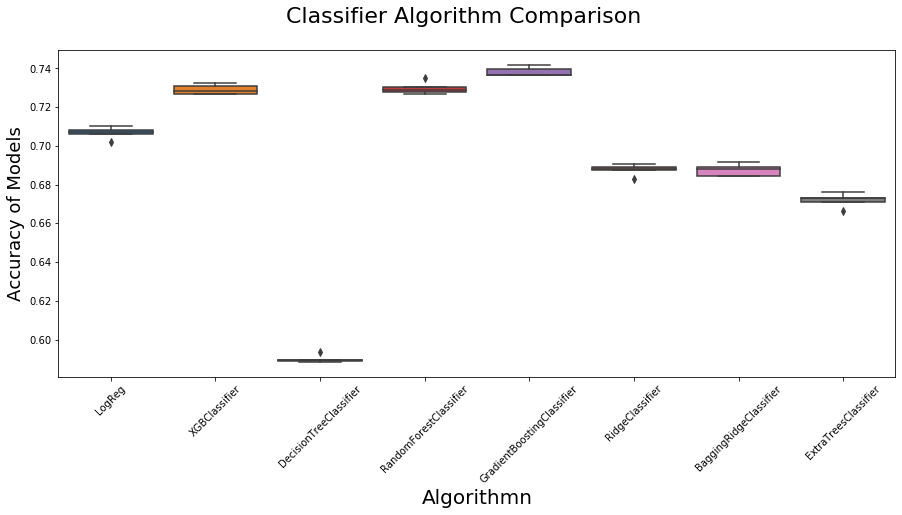

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.show()